# Problem #1

In [1]:
import os
import matlab.engine
eng = matlab.engine.start_matlab()
eng.addpath(os.path.realpath('.'),nargout=0)

In [15]:
import numpy as np

light = np.random.uniform(size=(31,))
light_mat = matlab.double(light.tolist())
primaries = np.random.uniform(size=(31,3))
primaries_mat = matlab.double(primaries.tolist())

In [16]:
eng.humanColorMatcher(light_mat, primaries_mat)

MatlabExecutionError: 
  File /Users/reubenfeinman/Dropbox/NYU/math_tools/homeworks/hw2_Feinman/humanColorMatcher.p, line 0, in humanColorMatcher
TESTLIGHT must be a column vector (or matrix of column vectors) containing the spectral distribution of a test light, sampled from 400 to 700 nm (31 samples)


# Problem #2

In [20]:
import scipy.io as sio

data = sio.loadmat('./regress1.mat')
x = data['x']
y = data['y']

In [23]:
%matplotlib inline
import matplotlib.pylab as plt

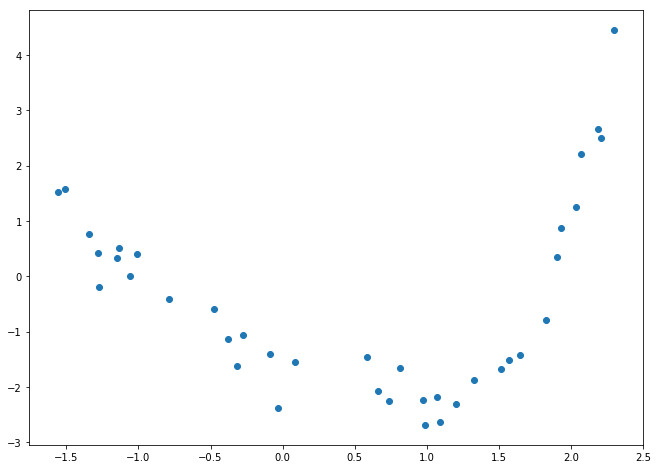

In [30]:
plt.figure(figsize=(11, 8))
plt.scatter(x,y)
plt.show()